<a href="https://colab.research.google.com/github/egyan175-creator/F1-Laptime-Prediction/blob/main/Hungary'23Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,)

race = pd.read_csv('hungary2023_raw_laps.csv')
race.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:32.264000,VER,1,0 days 00:01:27.912000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:30.370000,...,False,Red Bull Racing,0 days 01:02:04.106000,2023-07-23 13:03:06.134,12,1.0,False,NaN,False,False
1,0 days 01:04:57.421000,VER,1,0 days 00:01:25.157000,2.0,1.0,NaN,NaN,0 days 00:00:30.527000,0 days 00:00:30.848000,...,False,Red Bull Racing,0 days 01:03:32.264000,2023-07-23 13:04:34.292,1,1.0,False,NaN,False,True
2,0 days 01:06:22.491000,VER,1,0 days 00:01:25.070000,3.0,1.0,NaN,NaN,0 days 00:00:30.491000,0 days 00:00:30.724000,...,False,Red Bull Racing,0 days 01:04:57.421000,2023-07-23 13:05:59.449,1,1.0,False,NaN,False,True
3,0 days 01:07:47.033000,VER,1,0 days 00:01:24.542000,4.0,1.0,NaN,NaN,0 days 00:00:30.403000,0 days 00:00:30.495000,...,False,Red Bull Racing,0 days 01:06:22.491000,2023-07-23 13:07:24.519,1,1.0,False,NaN,False,True
4,0 days 01:09:11.876000,VER,1,0 days 00:01:24.843000,5.0,1.0,NaN,NaN,0 days 00:00:30.395000,0 days 00:00:30.707000,...,False,Red Bull Racing,0 days 01:07:47.033000,2023-07-23 13:08:49.061,1,1.0,False,NaN,False,True


In [10]:
time_cols = [col for col in race.columns if 'time' in col.lower()]
for col in time_cols:
    race[col] = pd.to_timedelta(race[col], errors='coerce').dt.total_seconds()


In [11]:
X = race.copy()
y= X.pop('LapTime')

#label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

for colname in X.select_dtypes("bool"):
  X[colname] = X[colname].astype("int64")

#imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

discrete_features = X.dtypes == int


In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]
print(mi_scores.head(20))
print(mi_scores.tail(20))



Sector2Time           1.321221
Sector3Time           1.086835
LapStartDate          0.940502
Sector1Time           0.860876
LapNumber             0.443606
SpeedI2               0.437810
LapStartTime          0.401841
Sector2SessionTime    0.398803
Sector3SessionTime    0.398226
Time                  0.398172
Sector1SessionTime    0.378953
Driver                0.331020
DriverNumber          0.317916
Stint                 0.308356
Position              0.283356
Team                  0.245411
IsAccurate            0.222631
SpeedFL               0.187010
SpeedST               0.121696
SpeedI1               0.119887
Name: MI Scores, dtype: float64
Sector1SessionTime    0.378953
Driver                0.331020
DriverNumber          0.317916
Stint                 0.308356
Position              0.283356
Team                  0.245411
IsAccurate            0.222631
SpeedFL               0.187010
SpeedST               0.121696
SpeedI1               0.119887
PitOutTime            0.106029
TyreLif

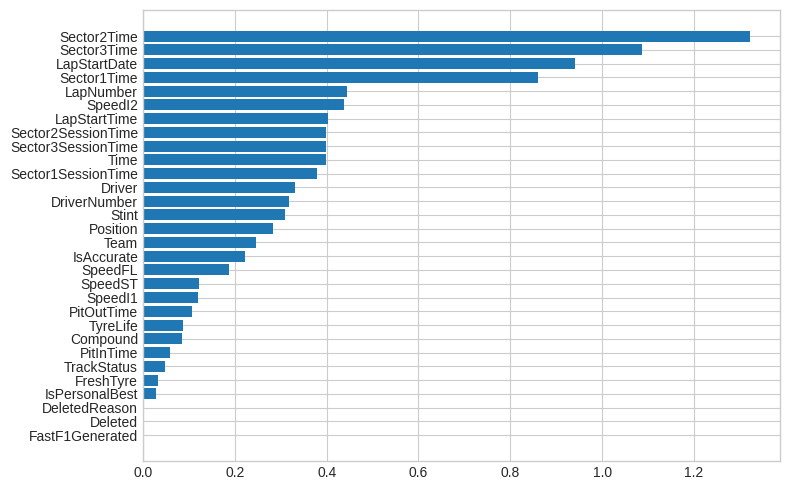

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)


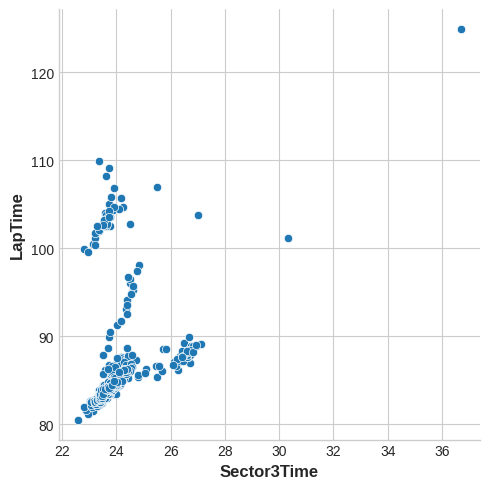

In [14]:
sns.relplot(x="Sector3Time", y="LapTime", data=race)


In [15]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

In [16]:
selected_features = ['Sector3Time','Sector2Time','Sector1Time']
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]
print(selected_features)

['Sector3Time', 'Sector2Time', 'Sector1Time']


In [17]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)


my_model.fit(X_train_selected, y_train, verbose=False)
predictions = my_model.predict(X_valid_selected)
score = cross_val_score(my_model, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
print(score)
print("MAE:", mean_absolute_error(predictions, y_valid))

[-0.42701592 -0.14165724 -0.11940646 -0.17802534 -0.11851469]
MAE: 0.15263673017889387


In [18]:

my_model_all_features = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

my_model_all_features.fit(X_train, y_train, verbose=False)
predictions_all_features = my_model_all_features.predict(X_valid)
score_all_features = cross_val_score(my_model_all_features, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(score_all_features)
print("MAE with all features:", mean_absolute_error(predictions_all_features, y_valid))

[-0.44104177 -0.21784807 -0.11757767 -0.16174549 -0.10758426]
MAE with all features: 0.11020679197273424


In [19]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train_selected, y_train)
predictions_2nd_model = linear_model.predict(X_valid_selected)
score_2nd_model = cross_val_score(linear_model, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
print(score_2nd_model)
print("MAE with all features:", mean_absolute_error(predictions_2nd_model, y_valid))

[-0.40580174 -0.31951887 -0.25894964 -0.33964779 -0.28288951]
MAE with all features: 0.388000127853491
